# CSD y CM de Actividad Evocada. 
Usemos esto como opurtunidad para poner todo el código en orden.


En este *notebook* de Julia implementaremos métodos numéricos para llevar a cabo un análisis de *centro de masa* (promedio vectorial) de la densidad de pozos y fuentes de corriente sobre una rebanada del hipocámpo de una rata. En este Notebook estudiaremos los datos de los experimentos evocados que hizo Franco en Agosto.
 Al parecer primero toca hacer una prueba con todo aquí mismo antes que hacer un modulo ordenado por una inconveniencia al hacer modulos (no se pueden recargar).

In [1]:
using HDF5

In [2]:
function AbreyCheca(x::AbstractString)
    #Abre el archivo de brw (acepta el nombre tal cual)
    archivo=h5open(x)
    #sacatito todas las variables que te interesan
    numcuadros=archivo["/3BRecInfo/3BRecVars/NRecFrames"][1][1]
    frecuencia=archivo["/3BRecInfo/3BRecVars/SamplingRate"][1][1]
    maxvolt=archivo["/3BRecInfo/3BRecVars/MaxVolt"][1][1]
    minvolt=archivo["/3BRecInfo/3BRecVars/MinVolt"][1][1]
    bitdepth=archivo["/3BRecInfo/3BRecVars/BitDepth"][1][1]
    duracionexperimento=numcuadros/frecuencia
    factordeescala=(maxvolt-minvolt)/2^bitdepth
    DatosCrudos=read(archivo["/3BData/Raw"])
    result=Dict("numcuadros" => numcuadros,
                "frecuencia"=> frecuencia,
                "maxvolt" => maxvolt,
                "minvolt" => minvolt,
                "bitdepth" => bitdepth,
                "duracion" => duracionexperimento,
                "factor " => factordeescala,
                "DatosCrudos"=>DatosCrudos )
    return result
                    
end

AbreyCheca (generic function with 1 method)

In [3]:
Datos=AbreyCheca("050815_1R4.brw")

Dict{ASCIIString,Any} with 8 entries:
  "minvolt"     => -4125.0
  "maxvolt"     => 4125.0
  "factor "     => 2.01416015625
  "frecuencia"  => 7020.800706028248
  "DatosCrudos" => 4096x210624 Array{UInt16,2}:…
  "bitdepth"    => 0x0c
  "numcuadros"  => 210624
  "duracion"    => 29.99999698312937

In [4]:
function EncuentraTrancazosRaw(datos::Array, tolerancia=1400)
    result=Int[]
    longitud=length(datos)
    jcomp=0
    for j=1:longitud
        if abs(datos[j])>tolerancia
            if j-jcomp>1
                push!(result,j)
            end
            jcomp=j
        end
    end
    return result
end


EncuentraTrancazosRaw (generic function with 2 methods)

In [5]:
exemplo=vec(Datos["DatosCrudos"][2000,:]);

In [6]:
listongas=EncuentraTrancazosRaw(exemplo)

3-element Array{Int64,1}:
  43890
 114498
 185107

In [7]:
function ActivAlrededorTrancazo(Lista::Array, xxs::Array)
    #Aqui no se le ha hecho reshape a las matrices todavia
    result=Dict{AbstractString, Array}()
    q=1
    desde=20
    hasta=480
    for j in Lista
        nomineclave="Trancazo_$q"
        result[nomineclave]=xxs[:,j-desde:j+hasta]
        #println(nomineclave)
        q+=1
    end
    return result
end


ActivAlrededorTrancazo (generic function with 1 method)

In [8]:
ActividadRaw=ActivAlrededorTrancazo(listongas, Datos["DatosCrudos"])

Dict{AbstractString,Array{T,N}} with 3 entries:
  "Trancazo_2" => 4096x501 Array{UInt16,2}:…
  "Trancazo_1" => 4096x501 Array{UInt16,2}:…
  "Trancazo_3" => 4096x501 Array{UInt16,2}:…

In [9]:
function FormaMatrizDatosCentrados(xxs::Array)
    #El array tiene que ser de 4096 por algo mas
    irrrelevante,largo=size(xxs)
    aux=Array(Int32, 64,64, largo);
    for j=1:64,k=1:64
        aux[k,j,:]=xxs[j+(k-1)*64,:]
    end
    result=round(Int32,aux)*(-1)+2048;
    aux=0
    return result
end

FormaMatrizDatosCentrados (generic function with 1 method)


Hay un montonal de canales que por la forma en que requiere ser hecho el experimento no detectaron nada o casi nada. Esos aparecen el registro como saturados en el máximo valor posible. Dado que esto es MUY inconveniente para el cálculo del CM, tenemos que detectarlos automáticamente y ponerlos en cero o ver si los esquivamos.

In [10]:
DatosCentrados=Dict{AbstractString, Array}()
for k in keys(ActividadRaw)
    DatosCentrados[k]=FormaMatrizDatosCentrados(ActividadRaw[k])
end

In [11]:
function BuscaSaturados(datos::Array, saturavalue=1700)
    (ancho,alto,largo)=size(datos)
    result=Set{Array{Int,1}}()
    arreglostd=zeros(ancho,alto)
    arregloprom=zeros(ancho,alto)
    for j=1:ancho, k=1:alto
        prom=mean(datos[k,j,:])
        arregloprom[k,j]=prom
        desviacion=std(datos[k,j,:])
        arreglostd[k,j]=desviacion
        if abs(prom)>saturavalue || desviacion<10
            push!(result, [k,j])
        end
    end
    return (result,arreglostd, arregloprom)
end

BuscaSaturados (generic function with 2 methods)

In [12]:
DictSaturados=Dict{AbstractString, Tuple}()
for k in keys(DatosCentrados)
    DictSaturados[k]=BuscaSaturados(DatosCentrados[k])
end

In [13]:
function vecindad8(punto::Array)
    j=punto[1]
    k=punto[2]
    result=Set{Array{Int64,1}}()
    push!(result, [j-1,k-1])
    push!(result, [j-1,k])
    push!(result, [j-1,k+1])
    push!(result, [j,k-1])
    push!(result, [j,k+1])
    push!(result, [j+1,k-1])
    push!(result, [j+1,k])
    push!(result, [j+1,k+1])
    return result
end

vecindad8 (generic function with 1 method)

Parece ser que promediar los canales saturados sobre sus vecinos no es tan buena idea. Puede ser que incluso meta hipótesis superfluas sobre la CSD, als sobre suavizar esos puntos. Además, un sólo pase no basta para quitar la saturación. Así que la función de abajo no es taaan buena idea.

In [14]:
function PromediaSaturados!(malos::Set, xxs::Array)
    
    #Es mejor hacer esto Frame por Frame aunque sea lento.
    result=zeros(xxs)
    temp=copy(xxs)
    #Primero, hacemos el padding de los datos.
    temp=vcat(temp[1,:], temp, temp[end,:])
    temp=hcat(temp[:,1], temp, temp[:,end])
#    println(size(temp))
    for q in malos
        prome=0
        for p in vecindad8(q)
   #         println(p)
   #         println(temp[p[1],p[2]])
            #tus vecindades, por el padding, estan desplazadas +1
            prome+=temp[p[1]+1,p[2]+1]
        end
        prome/=8
        xxs[q[1],q[2]]=prome
    end
    return
end

PromediaSaturados! (generic function with 1 method)

In [15]:
function imitaruido(x::Array)
    #Esta funcion asume que x es ruido gaussiano y lo imita.
    sigma=std(x)
    prom=mean(x)
    l=length(x)
    result=sigma*randn(l)+prom
    return result
end

imitaruido (generic function with 1 method)

In [16]:
TestArray1=map(Float32, DatosCentrados["Trancazo_1"][:,:,100]);
TestMalos=DictSaturados["Trancazo_1"][1];

In [17]:
PromediaSaturados!(TestMalos,TestArray)

LoadError: LoadError: UndefVarError: TestArray not defined
while loading In[17], in expression starting on line 1

In [18]:
q=[10,45]
in(q,TestMalos)

false

In [19]:
bla=vcat(vec(DatosCentrados["Trancazo_1"][10,45,:])
,vec(DatosCentrados["Trancazo_2"][10,45,:]), 
vec(DatosCentrados["Trancazo_3"][10,45,:]))
cuac=hist(bla, -200:5:200)


(-200:5:200,[0,0,0,0,0,0,0,0,0,0  …  0,0,0,0,0,0,0,0,0,0])

In [20]:
sigma=std(bla)
prom=mean(bla)
(prom,sigma)

(-0.12974051896207583,66.1456333201427)

In [21]:
bla2=imitaruido(bla)
cuac2=hist(bla2,-200:5:200)
mean(bla2),std(bla2)

(-1.7713121966309149,68.8466163893645)

In [22]:
using PyPlot

In [23]:
mu=0.165
sigma=84
function gauss(x)
    return 1/(sqrt(2*pi)*sigma)*exp(-((x-mu)/sigma)^2/2)
end

gauss (generic function with 1 method)

In [34]:
xdata=collect(cuac[1][2:end])
measuredata=cuac[2];

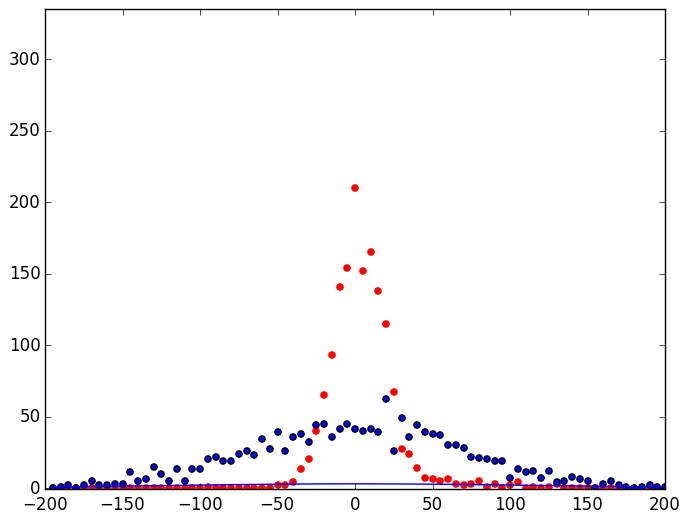

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f69a0b7dd68>

In [31]:
xlim(-200,200)
ylim(-1,335)
scatter(xdata,measuredata, color="red")
scatter(cuac2[1][2:end],cuac2[2])
plot(cuac[1][2:end], map(x->sqrt(1801*gauss(x)),cuac[1][2:end]))

In [48]:
using LsqFit

In [42]:
function matazeros(xxs::Array, yys::Array)
    largo=length(yys)
    xdepurada=copy(xxs)
    ydepurada=copy(yys)
    for j=largo:-1:1
        if yys[j]==0 
            deleteat!(xdepurada, j)
            deleteat!(ydepurada,j)
        end
    end
    return (xdepurada,ydepurada)
end


matazeros (generic function with 1 method)

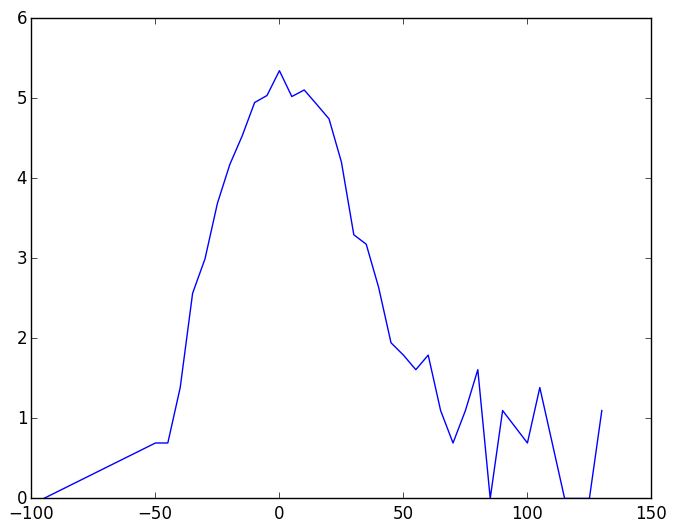

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f69a0ac12e8>

In [45]:
(ar,ur)=matazeros(xdata,measuredata)
plot(ar, log(ur))

In [49]:
#LsqFit no es bueno ajustando gaussianas, hagamos que ajuste un polinomio.
#function ajustaGaussiana(xxs::Array,yys::Array)
yys=ur
xxs=ar
model(x,p)=p[3]+x.*p[2]+x.^2.*p[1]
ydata=log(yys)
    rara=curve_fit(model,xxs,ydata, [0.5,0.5,0.5])
#    return rara.fitparam
#end
   



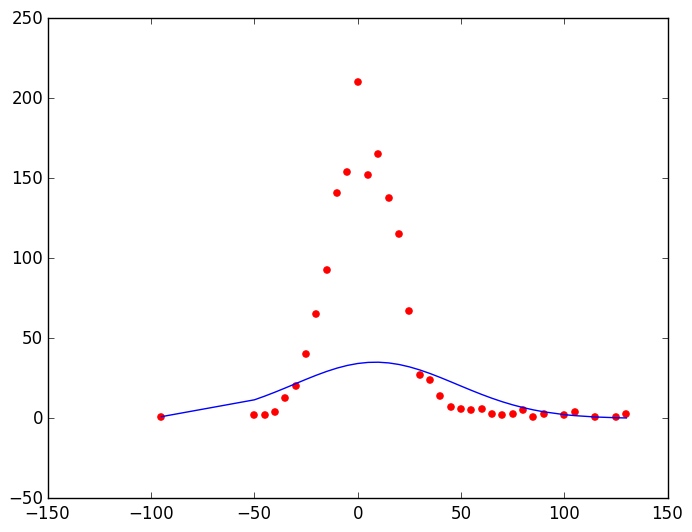

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f69a08442e8>

In [55]:
rara.param
uiriruri=map(x->model(x,rara.param),ar)
scatter(ar,ur, color="red")
plot(ar, exp(uiriruri))


In [48]:
ajustaGaussiana(xdata,measuredata)

LoadError: LoadError: MethodError: `eps` has no method matching eps(::Type{Int64})
while loading In[48], in expression starting on line 1

In [ ]:
fiteado=curve_fit(model,fakexdata,ydata, [0.5,0.5])

In [ ]:
?power_by_squaring

In [ ]:
imagen=imshow(TestArray,interpolation="nearest")
cb=colorbar(imagen)